In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp 
import os, sys, glob
import matplotlib as mpl
from matplotlib import pylab as plt
import wave
import pyaudio  
from datetime import timedelta, datetime

In [5]:
def timecodematch(x, base_date):
    delta = []
    b_d = datetime.strptime(base_date, "%H:%M:%S:%f")
    for y in range(len(x)):
        d = datetime.strptime(x[y], "%H:%M:%S:%f")
        delta.append(abs(d - b_d))
    return delta

def getSec(minutes,sec):
    print str(minutes*60 + sec) + ' sec'

def getMin(sec):
    print str(int(np.floor(sec/60))) + ' min ' + str(np.mod(sec,60)) + ' sec'

def playMusic(s1,s2):
    f = wave.open('music/Science_of_Disco_Set_16bit.wav')
    chunk = 1024
    p = pyaudio.PyAudio()  
    stream = p.open(format = p.get_format_from_width(f.getsampwidth()),  
                    channels = f.getnchannels(),  
                    rate = f.getframerate(),  
                    output = True)  
    count = 0
    d = f.readframes(chunk)
    while d != '':
        d = f.readframes(chunk)
        count += 1  
        if count >= s1*(f.getframerate()/chunk) and not count > s2*(f.getframerate()/chunk):
            stream.write(d)

    stream.stop_stream()  
    stream.close()  
    p.terminate()  

# Reading Accel data

In [6]:
# Read in data for each subject between start and end times

sampling_freq = 1000 # in milliseconds
beginTS = '20:29:33:113' # from 'data/76.csv'
endTS   = '21:00:20:802' # from 'data/76.csv'
da = datetime.strptime(endTS, "%H:%M:%S:%f") - datetime.strptime(beginTS, "%H:%M:%S:%f")
totMS = ((da.seconds * 1000000) + da.microseconds) / 1000

gforce_all = []
sub = []

count = 1
countall = 1

plotting = False
zeroGravity = False 

for file in glob.glob("data/*.csv"):
    
    s = os.path.splitext(os.path.split(file)[1])[0]
                  
    try:        

        df = pd.read_csv(file, delimiter=';')        

        print '                      subject ' + s + ', start time: ' + df['time'].get_values()[0] + ', end time: ' + df['time'].get_values()[-1]

        startTime = np.argmin(timecodematch(df['time'].get_values(), beginTS))
        endTime = np.argmin(timecodematch(df['time'].get_values(), endTS))

        # instead, try interpolating to specific time intervals:
        time_s = df['time'].get_values()[startTime:endTime]
        gforce_s = df['gforce'].get_values()[startTime:endTime]

        if plotting:
            fig, (ax1, ax2) = plt.subplots(2)
            ax1.plot(gforce_s)

        ts = timecodematch(time_s, beginTS)
        for t in range(len(time_s)):
            time_s[t] = ((ts[t].seconds * 1000000) + ts[t].microseconds) / 1000
        
        # !!! check interpolation method. Probably better ways to do this:
        gforce_interp = np.interp(range(0,totMS,sampling_freq), 
                                    np.array(time_s, dtype=np.float64), 
                                    np.array(gforce_s, dtype=np.float64))

        if zeroGravity: # take absolute value to account for decrease in gforce
            gforce_interp = abs(gforce_interp - 1)                

        if plotting:
            ax2.plot(gforce_interp)

        if s not in ['15','35','37','40','42','47','48','66','67','76']: # removed from visual inspection of plots & '76' 

            gforce_all.append(gforce_interp)
            sub.append(s)
            print "good: " + str(count) + " of total: " + str(countall)
            count += 1
        
        else:
            print "removed: subject " + str(s)
        countall += 1

    except:
        print "bad: subject " + str(s)
        countall += 1
        pass

gforce_mean = np.mean(gforce_all, axis=0)

print "percentage good: " + str(count/float(countall))

                    subject 10, start time: 19:57:58:3, end time: 20:13:00:6
bad: subject 10
                    subject 11, start time: 20:14:32:301, end time: 21:25:59:245
good: 1 of total: 2
                    subject 13, start time: 20:29:47:906, end time: 21:35:43:960
good: 2 of total: 3
                    subject 14, start time: 20:28:38:990, end time: 21:08:15:422
good: 3 of total: 4
                    subject 15, start time: 20:46:01:9, end time: 21:03:26:6
removed: subject 15
                    subject 16, start time: 19:55:57:462, end time: 21:10:16:567
good: 4 of total: 6
                    subject 17, start time: 19:36:37:265, end time: 21:23:29:78
good: 5 of total: 7
                    subject 18, start time: 19:39:36:7, end time: 19:54:56:4
bad: subject 18
                    subject 19, start time: 19:45:43:8, end time: 20:00:44:7
bad: subject 19
                    subject 2, start time: 19:58:57:323, end time: 21:09:13:424
good: 6 of total: 10
                   

In [17]:
# Smoothing:
# !!! might be better way to smooth data. Currently using Gaussian kernel with:

smoothingSize = 20 # in seconds

from scipy.ndimage.filters import gaussian_filter

# normalize data
gforce_all_normed = []
for i in range(len(gforce_all)):
    gforce_all_normed.append((gforce_all[i] - np.mean(gforce_all[i])) / np.std(gforce_all[i]))

# smooth data
gforce_all_smoothed = []
for i in range(len(gforce_all)):
    gforce_all_smoothed.append(gaussian_filter(gforce_all_normed[i], sigma=smoothingSize))

# get mean gforce across individuals:
gforce_mean = np.mean(gforce_all_smoothed, axis=0)

/Applications/miniconda3/envs/topography/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


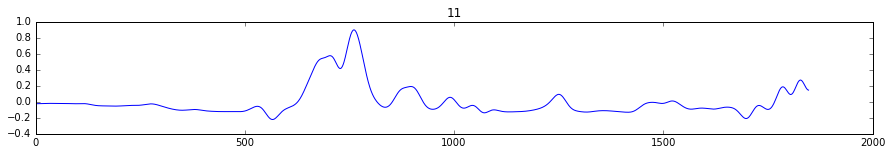

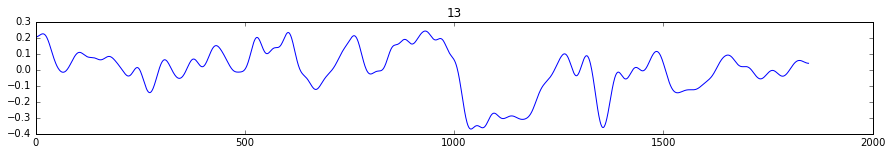

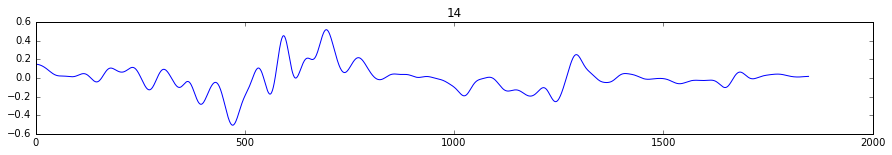

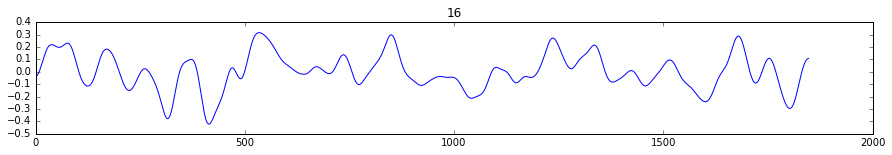

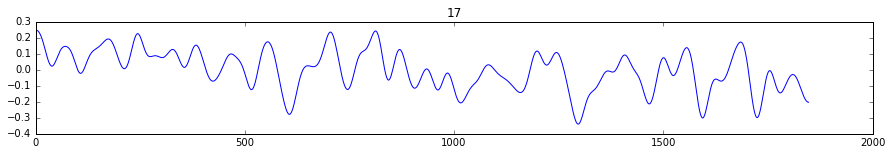

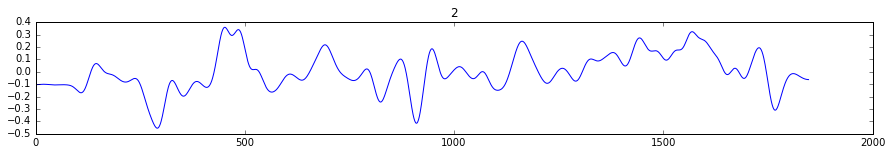

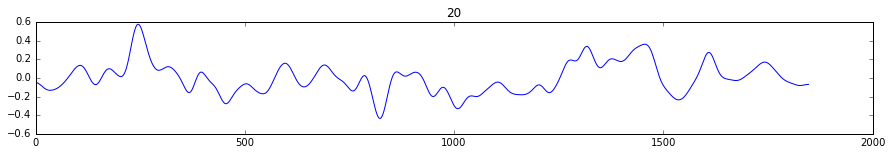

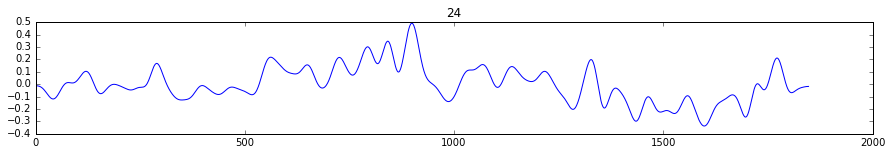

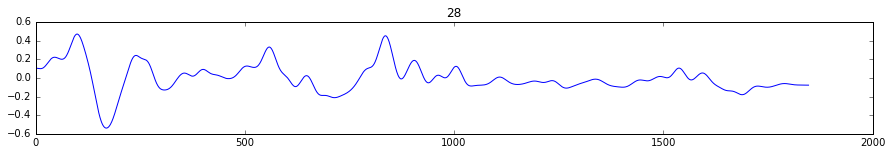

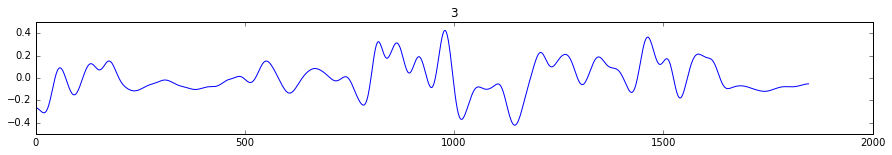

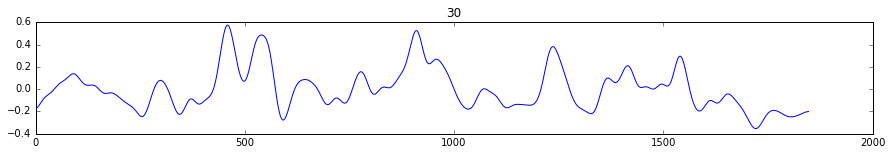

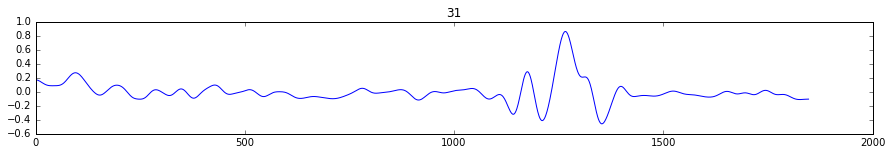

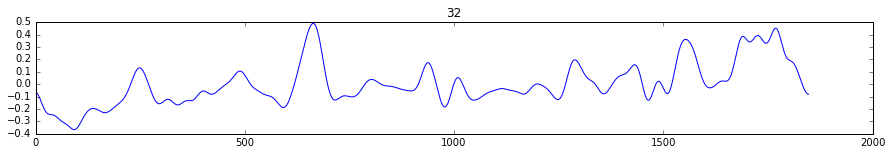

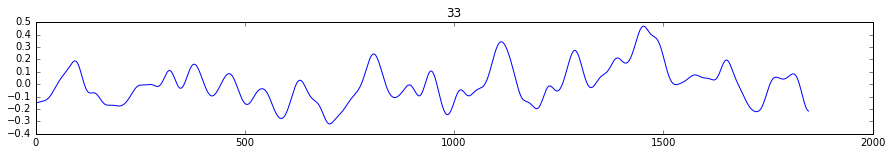

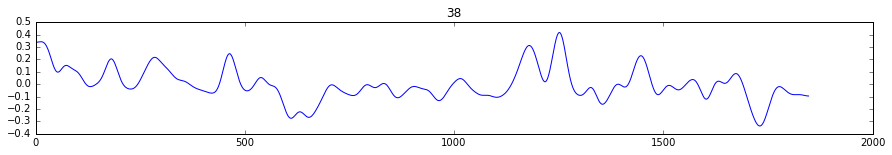

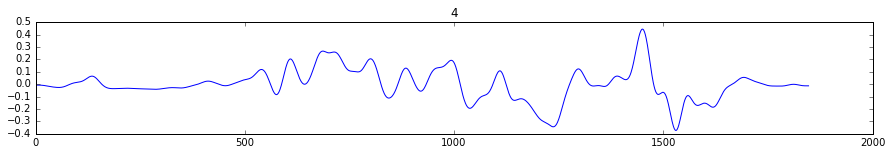

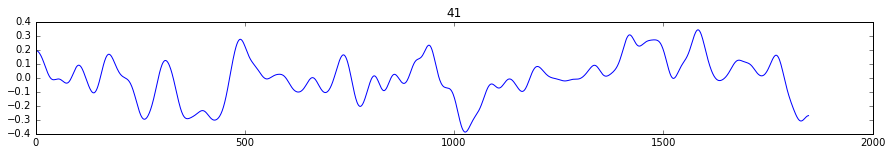

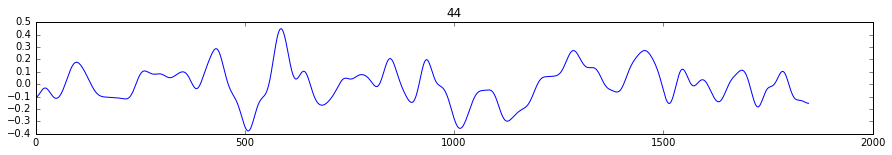

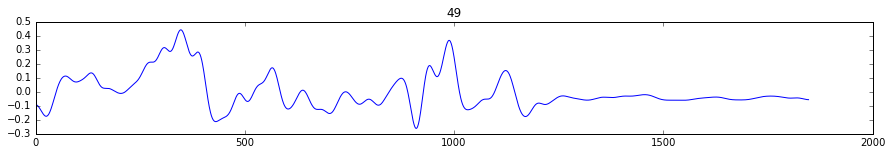

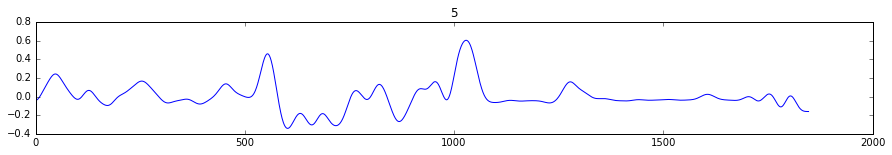

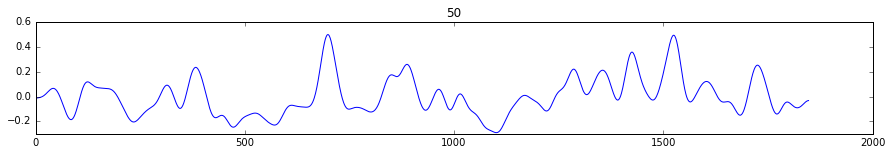

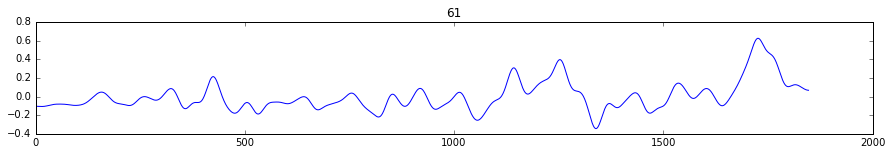

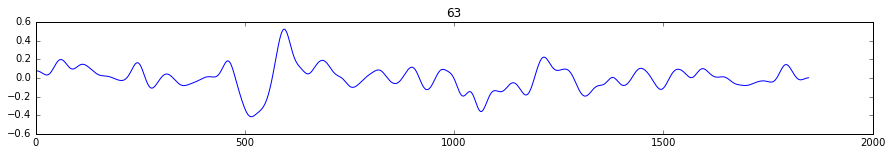

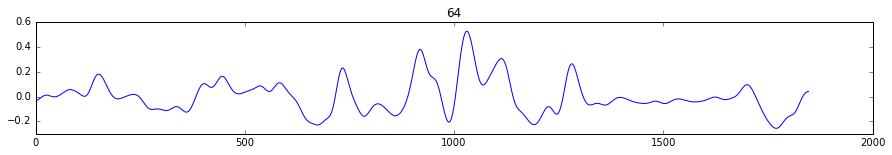

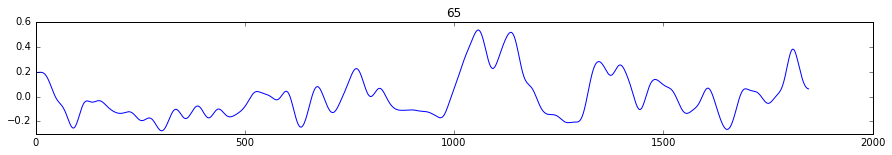

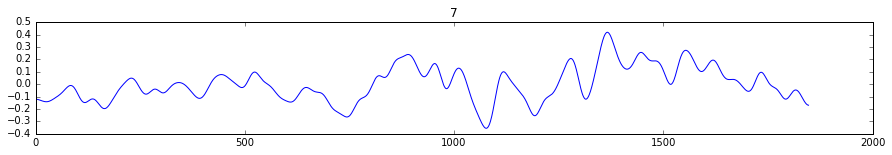

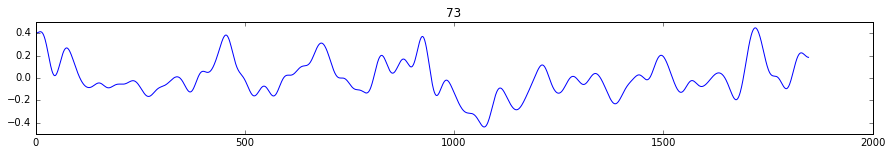

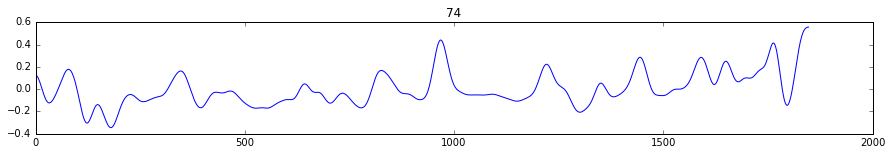

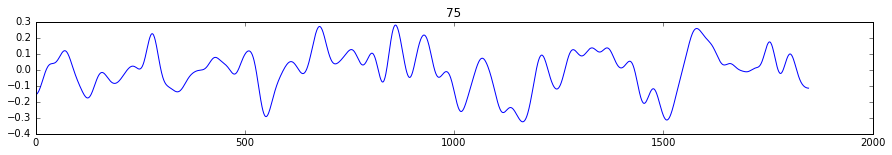

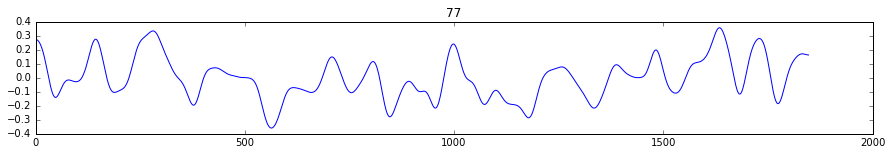

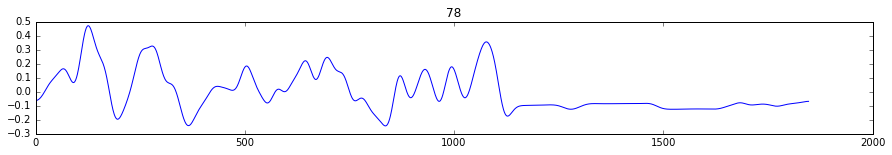

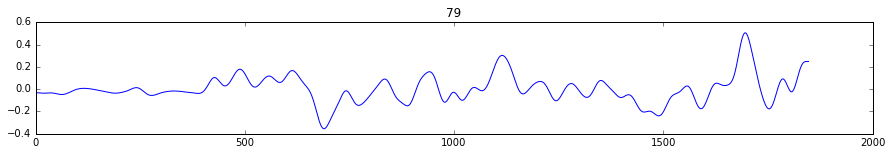

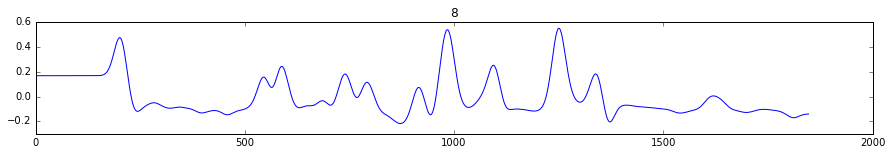

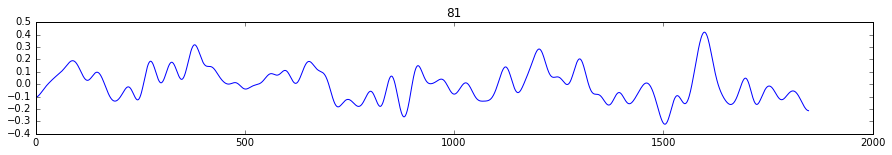

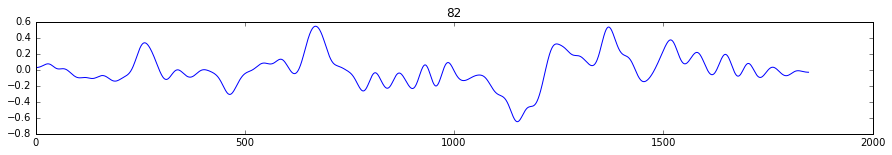

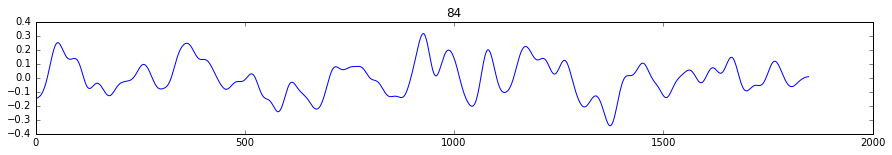

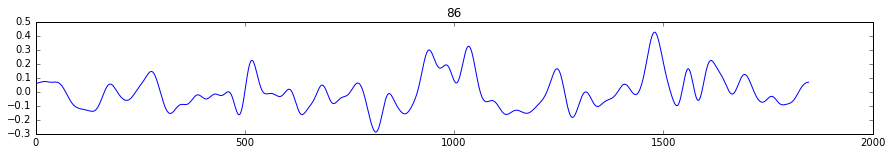

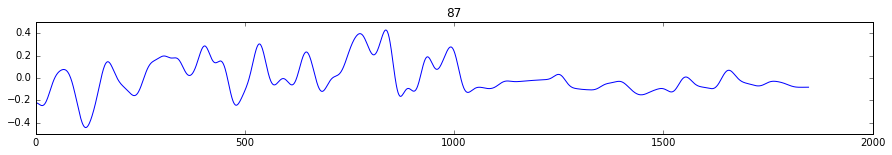

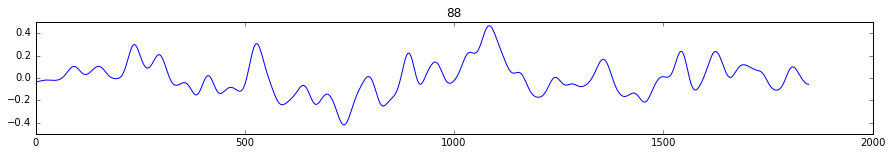

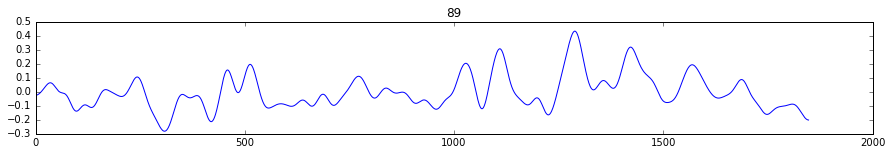

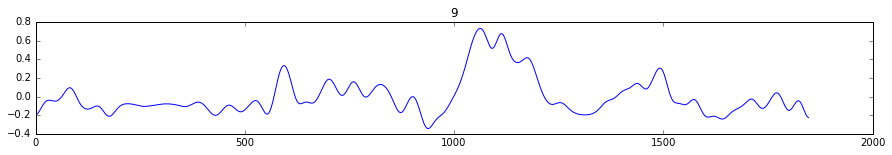

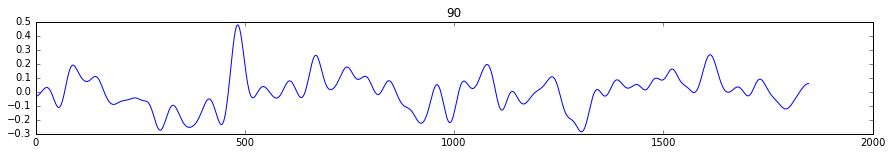

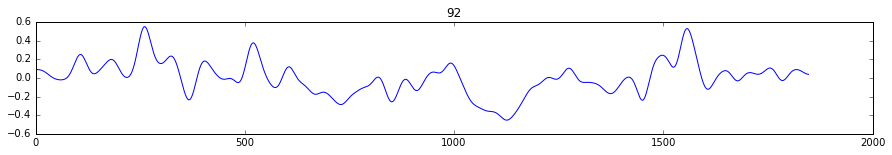

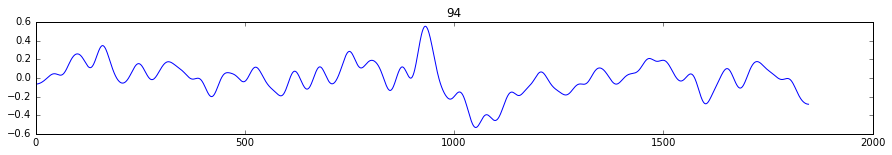

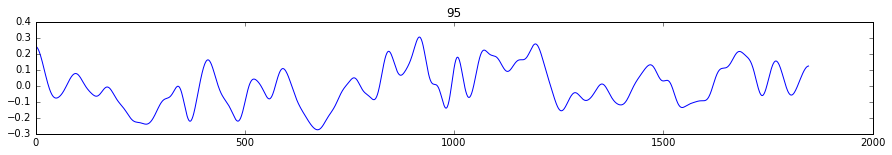

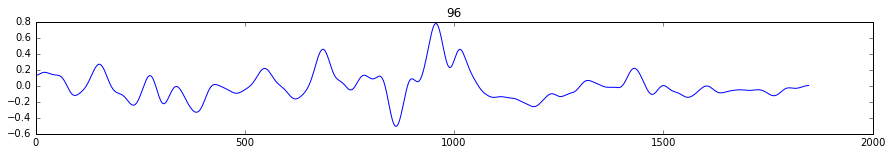

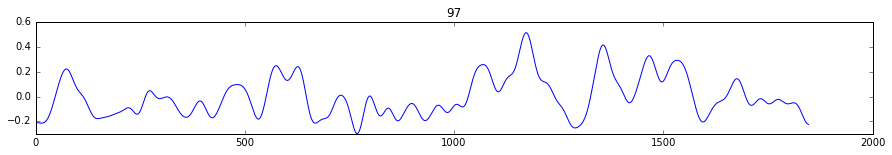

In [9]:
# Visually check timeseries of each 'good' participant:

for i in range(len(gforce_all_smoothed)):
    fig, ax1 = plt.subplots(1,figsize=(15,2))
    ax1.plot(gforce_all_smoothed[i])
    plt.title(str(sub[i]))

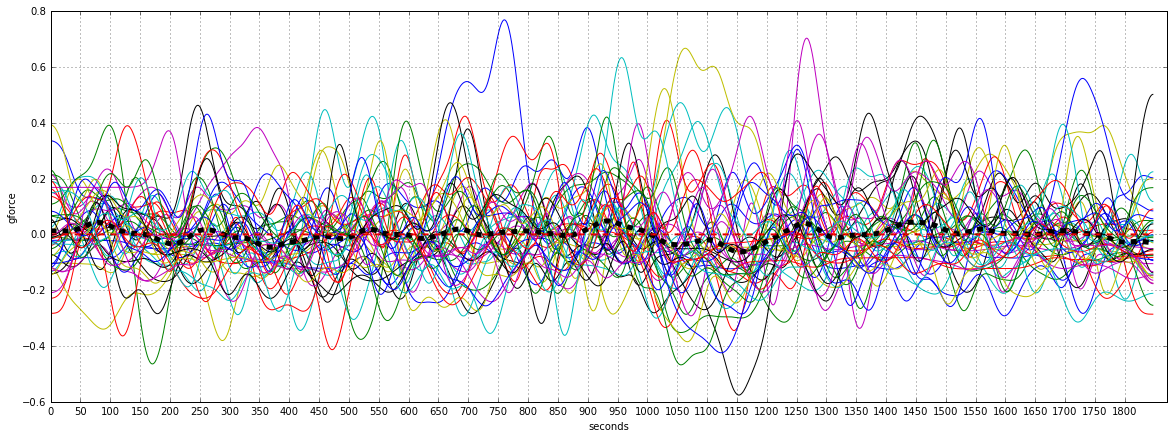

In [18]:
# Plotting group:

fig, ax1 = plt.subplots(1,figsize=(20,7))
for i in range(len(gforce_all_smoothed)):
    ax1.plot(gforce_all_smoothed[i])

ax1.plot(gforce_mean, 'k',linewidth=5,  linestyle='--')
ax1.plot(np.linspace(0,0,len(gforce_mean)), 'r', linewidth=2, linestyle='--')
plt.xticks(range(0,len(gforce_mean), 50), np.array(range(0,totMS,sampling_freq*50))/1000, rotation='0')
ax1.set_xlabel('seconds')
ax1.set_ylabel('gforce')
ax1.set_xlim(0,1870)
ax1.grid(True)
plt.show()

In [12]:
# functions for converting between sec and [min sec]
getMin(930)
#getSec(19,49)

15 min 30 sec


In [31]:
# function for playing music between start and end seconds
playMusic(1200,1210)

In [37]:
#import IPython
#IPython.display.Audio('music/Science_of_Disco_Set_16bit.wav')

## Phase synchrony notes:

In [32]:
# For phase clustering, instead try: https://github.com/alexminnaar/time-series-classification-and-clustering

In [33]:
# !!! the following isn't correct

import nitime.timeseries as ts
from nitime.analysis.coherence import CoherenceAnalyzer

np.set_printoptions(precision=4)  # for doctesting
t1 = ts.TimeSeries(data = np.array(gforce_all, dtype=np.float32), sampling_rate=1, time_unit='s')
c1 = CoherenceAnalyzer(t1)

print np.shape(np.array(gforce_all, dtype=np.float32))
print np.shape(c1.coherence)
print np.shape(c1.phase)

(47, 1848)
(47, 47, 33)
(47, 47, 33)
